In [68]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

## We base our first iteration on Unicycle Kinematics.
## https://www.mathworks.com/help/robotics/ug/mobile-robot-kinematics-equations.html
## x = [x,y,heading]^T
## u = [wheel_speed, heading_rate (rad/s)]^T


## Some constants
r = 0.1 # wheel radius

## Define our model
# x_dot = A*x + B*u
A = 0*np.identity(3)
def B(r,x):
    B = np.array([[r*np.cos(x[2]), 0],
                  [r*np.sin(x[2]), 0],
                  [0, 1]])
    return B

In [69]:
## Tuning parameters
v_k = np.array([1.0,1.0,1.0]) # process noise

w_k = np.array([1.0,1.0,1.0]) # sensor noise

Q_k = np.array([[0.5,   0,   0], # model noise covariance matrix
                [  0, 0.5,   0],
                [  0,   0, 0.5]])

H_k = np.array([[1.0,  0,   0], # observation matrix (also known as G_k, M_k)
               [  0, 1.0,   0],
               [  0,  0, 1.0]])

R_k = np.array([[1.0,   0,    0], # observation/estimate noise covariance matrix
                [  0, 1.0,    0],
                [  0,    0, 1.0]])


In [70]:
## IEKF function
def IEKF(z_k, x_k_min_1, u_k_min_1, P_k_min_1, T,iterative):
    
    # z_k: observation vector
    # x_k_min_1: previous state estimate
    # u_k_min_1: previous input
    # P_k_min_1: previous covariance matrix
    # T: time
    
    # Prediction phase
    x_k = A @ x_k_min_1 + B(r,x_k_min_1) @ (u_k_min_1) + w_k # predicted state estimate (x_frown)
    
    P_k = A @ P_k_min_1 @ A.T + Q_k # updated covariance matrix (pre-correction)
    
    
    
    # Correction phase (EKF)
    S_k = H_k @ P_k @ H_k.T + R_k
    
    y_k_hat = z_k - (H_k @ x_k + v_k) # measurement estimate
    
    K_k = P_k @ H_k.T @ inv(S_k) # near-optimal Kalman gain
    
    x_k_hat = x_k + K_k @ y_k_hat # updated state estimate prediction
    
    P_k = (np.identity(3) - K_k @ H_k) @ P_k # updated covariance matrix (post-correction)
    
    
    # Iterative phase (IEKF)
    if(iterative):
        x_op_k = x_k

        for i in range(10):
            x_k_hat = x_k + K_k @ (z_k - (H_k @ x_op_k + v_k) - H_k @ (x_k - x_op_k)) # updated state estimate prediction
            x_op_k = x_k_hat
    
    # Returning state estimate and covariance
    return x_k_hat, P_k

In [73]:
def simulate_robot():
    
    # Constants
    t_0 = 1 # time interval start
    T = 1 # total time interval
    
    # Initial values
    z_k = [] # sensor measurements
    x = []
    y = []
    yaw = []
    
    
    for i in range(0,2500):
        new_x = i*0.1
        new_y = new_x*new_x
        z_k.append([new_x,new_y,0.0])
        x.append(new_x)
        y.append(new_y)
        yaw.append(0.0)
    
    
    
    x_k_min_1 = np.array([0.0,0.0,0.0]) # initial state
    u_k_min_1 = np.array([0.0,0.0]) # initial input
    P_k_min_1 = 5*np.array([[0.1, 0, 0], # initial covariance
                          [0, 0.1, 0],
                          [0, 0, 0.1]])
    
    x_hat = []
    y_hat = []
    yaw_hat = []
    
    should_iterate = True
    
    #Iterate
    h = 0.01
    x_sim = np.array([0,0,0]).T
    wheelspeed = 5
    headingrate = 0.1
    
    x_sim_run = []
    x_sim_x = []
    x_sim_y = []
    x_sim_yaw = []
    
    t = np.arange(0,250,0.1)
    
    for k, z_k_obs in enumerate(z_k,start=t_0):
        
        u_sim = np.array([wheelspeed, headingrate]).T
        x_sim_dot = A@x_sim + B(r, x_sim)@u_sim
        x_sim = x_sim + x_sim_dot*h
        x_sim_x.append(x_sim[0])
        x_sim_y.append(x_sim[1])
        x_sim_yaw.append(x_sim[2])
        
        x_k_hat, P_k = IEKF(z_k_obs, x_k_min_1,u_k_min_1,P_k_min_1,T,should_iterate)
         
        # Get ready for the next timestep by updating the variable values
        x_k_min_1 = x_k_hat
        P_k_min_1 = P_k
        
        x_hat.append(x_k_hat[0])
        y_hat.append(x_k_hat[1])
        yaw_hat.append(x_k_hat[2])
    
    print(x_sim_run)
    plt.plot(x, y, label="trajectory")
    plt.plot(x_hat,y_hat, label="trajectory_hat")
    plt.legend()
    plt.show()
    plt.plot(yaw, label="yaw")
    plt.plot(yaw_hat, label="yaw_hat")
    plt.legend()
    plt.show()
    
    plt.plot(x_sim_x, x_sim_y, label="x and y sim")
    plt.legend()
    plt.show()

    plt.plot(t, x_sim_x, label="x_sim")
    plt.plot(t, x_sim_y, label="y_sim")
    plt.legend()
    plt.show()

    plt.plot(t, x_sim_yaw, label="yaw_sim")
    plt.legend()
    plt.show()
    

[]


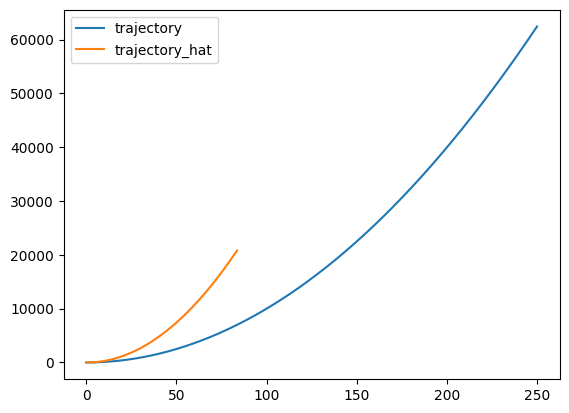

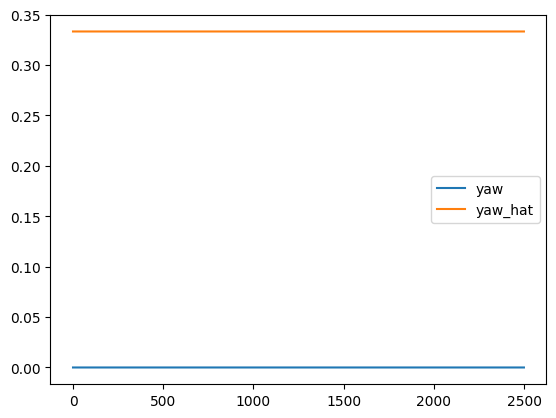

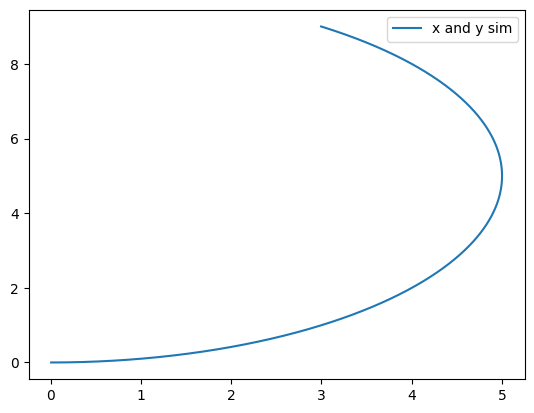

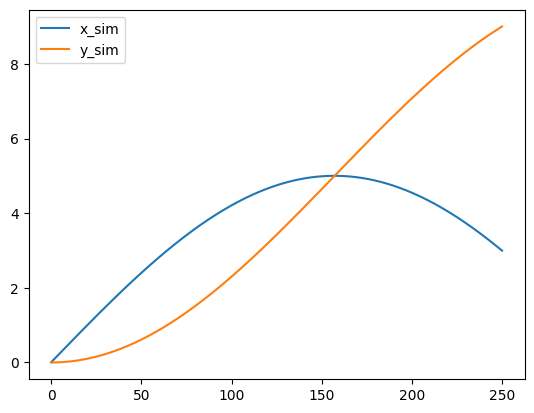

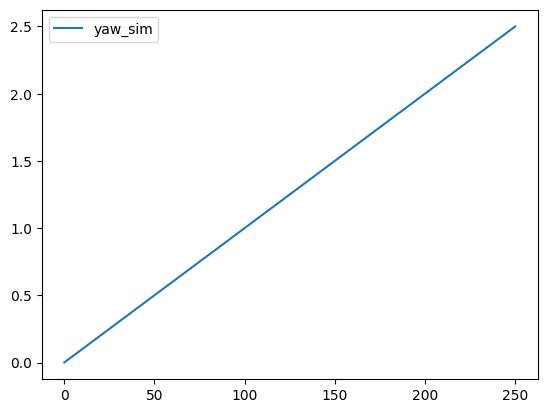

In [74]:
simulate_robot()